# Algae Example
This is a simplified lake algae dynamics model. We consider phytoplankton $A$, zooplankton $Z$ and nutrition $P$ (eg. phosphorus) available for $A$ in the water. The system is affected by the water outflow/inflow $Q$, incoming phosphorus load $P_{in}$ and temperature $T$. It is described as a simple predator - pray dynamics between $A$ and $Z$. The growth of $A$ is limited by the availability of $P$ and it depends on the water temperature $T$. The inflow/outflow $Q$ affects both $A$ and $P$, but not $Z$.

In [ ]:
# import required packages
import algaefunctions as algfun
import numpy as np
import scipy.io as sio
from pymcmcstat.MCMC import MCMC
from pymcmcstat.MCMCPlotting import MCMCPlotting

The data is saved in a `.mat` file as the original example comes from the Matlab.  We extract the necessary data as follows

In [ ]:
# load Algae data
algaedata = sio.loadmat('algaedata.mat')
# extract dictionary contents
adata = algaedata['data']
tx = adata['xdata'][0][0]
ty = adata['ydata'][0][0]
xlbls = adata['xlabels'][0][0][0]
ylbls = adata['ylabels'][0][0][0]

### Initialize MCMC Object
- Define data structure
- Assign parameters and define constraints
- Set simulation options and model settings

In [ ]:
# initialize MCMC object
mcstat = MCMC()
# initialize data structure 
mcstat.data.add_data_set(x = tx[:,0], y = ty[:,0:4], user_defined_object = tx)

# initialize parameter array
#theta = [0.5, 0.03, 0.1, 10, 0.02, 1.14, 0.77, 1.3, 10]
# add model parameters
mcstat.parameters.add_model_parameter(name = 'mumax', theta0 = 0.5, minimum = 0)
mcstat.parameters.add_model_parameter(name = 'rhoa', theta0 = 0.03, minimum = 0)
mcstat.parameters.add_model_parameter(name = 'rhoz', theta0 = 0.1, minimum = 0)
mcstat.parameters.add_model_parameter(name = 'k', theta0 = 10, minimum = 0)
mcstat.parameters.add_model_parameter(name = 'alpha', theta0 = 0.02, minimum = 0)
mcstat.parameters.add_model_parameter(name = 'th', theta0 = 1.14, minimum = 0, maximum = np.inf, prior_mu = 0.14, prior_sigma = 0.2)
# initial values for the model states
mcstat.parameters.add_model_parameter(name = 'A0', theta0 = 0.77, minimum = 0, maximum = np.inf, prior_mu = 0.77, prior_sigma = 2)
mcstat.parameters.add_model_parameter(name = 'Z0', theta0 = 1.3, minimum = 0, maximum = np.inf, prior_mu = 1.3, prior_sigma = 2)
mcstat.parameters.add_model_parameter(name = 'P0', theta0 = 10, minimum = 0, maximum = np.inf, prior_mu = 10, prior_sigma = 2)

# Generate options
mcstat.simulation_options.define_simulation_options(nsimu = int(1.0e3), updatesigma = 1)
# Define model object:
mcstat.model_settings.define_model_settings(sos_function = algfun.algaess, sigma2 = 0.01**2, S20 = np.array([1,1,2]), N0 = np.array([4,4,4]))

The code takes some time to run, so here we simply check to make sure the data structure can be processed using our sum-of-squares function.  Note, we have separate sum-of-squares for each quantity of interest and there will be a separate error variance for each as well.

In [2]:
# check model evaluation
theta = [0.5, 0.03, 0.1, 10, 0.02, 1.14, 0.77, 1.3, 10]
ss = algfun.algaess(theta, mcstat.data)
print('ss = {}'.format(ss))

ss = [ 930.44890289  521.2441601  1278.11736803]


## Run simulation
- We run an initialize sequence of 1000, then restart and perform another 5000

In [ ]:
# Run simulation
mcstat.run_simulation()
# Rerun starting from results of previous run
mcstat.simulation_options.nsimu = int(5.0e3)
mcstat.run_simulation(use_previous_results=True)

### Extract results and plot chain diagnostics
- chain panel
- density panel
- pairwise correlation panel


---------------------
name      :       mean        std
mumax     :     0.6553     0.2436
rhoa      :     0.0361     0.0129
rhoz      :     0.0991     0.0046
k         :    20.2803    10.5654
alpha     :     0.0231     0.0016
th        :     1.0063     0.0154
A0        :     0.9758     0.3048
Z0        :     2.0170     0.5183
P0        :     9.0378     0.9660


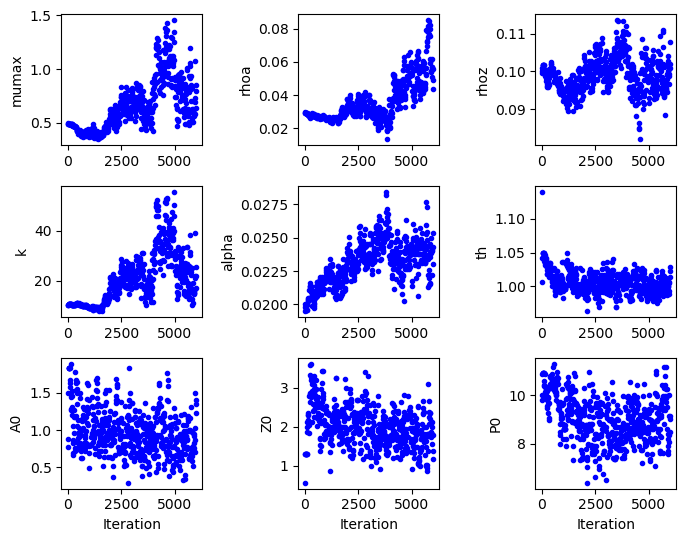

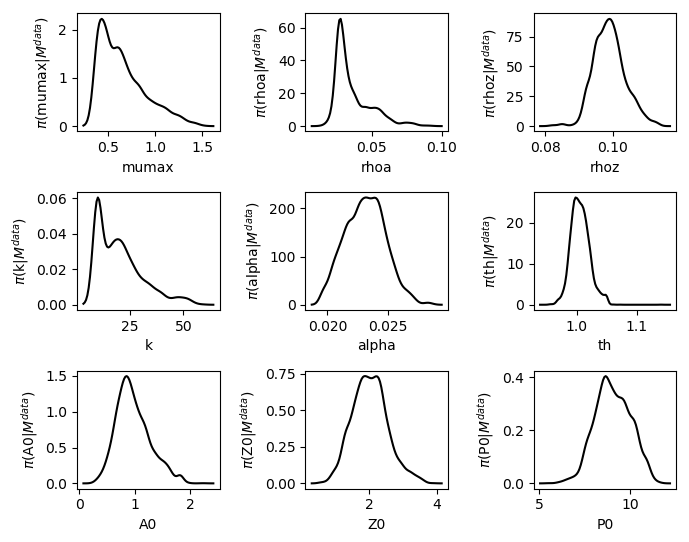

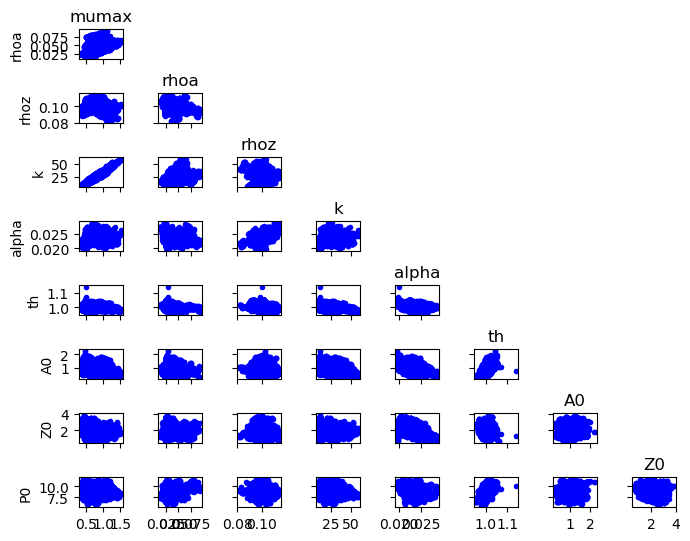

In [4]:
# extract info from results
results = mcstat.simulation_results.results
chain = results['chain']
s2chain = results['s2chain']
names = results['names'] # parameter names

# display chain stats
mcstat.chainstats(chain, results)

mcpl = MCMCPlotting()
# plot chain panel
mcpl.plot_chain_panel(chain, names, figsizeinches = [7, 6]);
# plot density panel
mcpl.plot_density_panel(chain, names, figsizeinches = [7, 6]);
# pairwise correlation
mcpl.plot_pairwise_correlation_panel(chain, names, figsizeinches = [7, 6]);

### Generate prediction/credible intervals for each quantity of interest

In [10]:
def predmodelfun(data, theta):
    obj = data.user_defined_object[0]
    time = obj[:,0]
    xdata = obj
    # last 3 parameters are the initial states
    y0 = np.array(theta[-3:])
    # evaluate model    
    tmodel, ymodel = algfun.algaefun(time, theta, y0, xdata)
    return ymodel

mcstat.PI.setup_prediction_interval_calculation(results = results, data = mcstat.data, modelfunction = predmodelfun)
mcstat.PI.generate_prediction_intervals(nsample = 500, calc_pred_int = 'on', waitbar = True)

Generating credible/prediction intervals:

 [-----------------100%-----------------] 500 of 500 complete in 22.9 sec
Interval generation complete



### Plot intervals

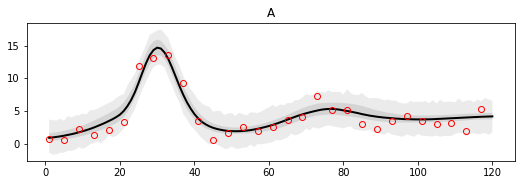

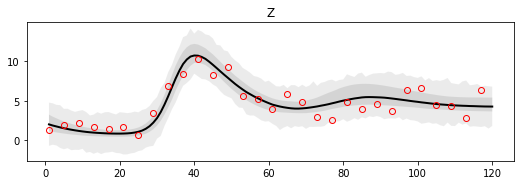

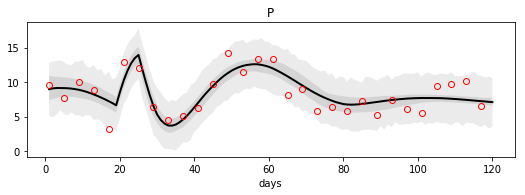

In [11]:
# plot prediction intervals
fighandle, axhandle = mcstat.PI.plot_prediction_intervals(adddata = False, addlegend=False, figsizeinches = [7.5,8])

for ii in range(3):
    axhandle[ii].plot(mcstat.data.ydata[0][:,0], mcstat.data.ydata[0][:,ii+1], 'ro', mfc='none')
    axhandle[ii].set_ylabel('')
    axhandle[ii].set_title(ylbls[ii+1][0])
axhandle[-1].set_xlabel('days');